In [1]:
from huggingface_hub import snapshot_download
import os

data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

urbansyn_dir = os.path.join(data_dir, 'urbansyn')
if not os.path.exists(urbansyn_dir):
    data_types = ['rgb', 'ss']
    for dt in data_types:
        print('downloading ' + dt + '...')
        snapshot_download(repo_id="UrbanSyn/UrbanSyn", repo_type="dataset", local_dir=urbansyn_dir, allow_patterns=f'{dt}/*')
        print('done')

In [2]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import transforms as T
from torchmetrics.segmentation import MeanIoU

from math import sqrt
from functools import partial

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from pytorch_lightning import LightningModule, Trainer, LightningDataModule
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.tuner import Tuner


Creating a DataModule

In [3]:
INV_NORMALIZE = T.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.255]
        )

In [4]:
NUM_CLASSES = 20
NUM_TRAIN = 6016
NUM_VAL = 7539 - 6016


def shift_class_indices(segmap):
    y = segmap + 1
    y[y==NUM_CLASSES] = 0
    return y


def albumentation_transform(transforms, x, y):
    transformed = transforms(image=x, mask=y)
    return  transformed['image'], transformed['mask']


class UrbanSynDataset(Dataset):
    def __init__(self, path, transforms, split='train', resized=True, downscaling=4, shift_class_indices=False):
        self.path = path
        self.transforms = transforms
        self.split = split
        self.resized = resized
        self.shift_class_indices = shift_class_indices
        if self.resized:
            size_str = str(1024//downscaling)
            if not os.path.exists(os.path.join(self.path, size_str)):
                self.path = os.path.join(self.path+'_resized', size_str)

    def __getitem__(self, index):
        if self.split=='val':
            i = index + NUM_TRAIN + 1
        else:
            i = index + 1
        if self.resized:
            x = np.load(os.path.join(self.path, 'rgb', f'rgb_{i:04}.npy'))
            y = np.load(os.path.join(self.path, 'ss', f'ss_{i:04}.npy'))
        else:
            x = np.array(Image.open(os.path.join(self.path, 'rgb', f'rgb_{i:04}.png')).convert('RGB'))
            y = np.array(Image.open(os.path.join(self.path, 'ss', f'ss_{i:04}.png')).convert('L'))
        x,y = albumentation_transform(self.transforms, x, y)
        if self.shift_class_indices:
            y = shift_class_indices(y)
        return x,y
    
    def __len__(self):
        if self.split=='train':
            return NUM_TRAIN
        elif self.split=='val':
            return NUM_VAL
        else:
            return NUM_TRAIN+NUM_VAL
        

class UrbanSynDataModule(LightningDataModule):
    def __init__(self, data_dir='./data/urbansyn', batch_size=16, downscaling=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.downscaling = downscaling
        self.train_transforms = A.Compose([
            A.HorizontalFlip(),
            A.ColorJitter(hue=0),
            A.Normalize(),
            ToTensorV2(),
            ])
        self.val_transforms = A.Compose([
            A.Normalize(),
            ToTensorV2(),
            ])

    def setup(self, stage: str):
        if stage == "fit":
            self.train_dataset = UrbanSynDataset(self.data_dir, self.train_transforms, 'train', downscaling=self.downscaling)
            self.val_dataset = UrbanSynDataset(self.data_dir, self.val_transforms, 'val', downscaling=self.downscaling)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

In [5]:
datamodule = UrbanSynDataModule()
datamodule.setup('fit')
for x,y in datamodule.train_dataloader():
    print(x.size(), y.size())
    print(torch.min(y), torch.max(y))
#     plt.imshow(rearrange(INV_NORMALIZE(x[0]), 'c h w -> h w c'))
    break

preds = torch.rand(16, 20, 256, 512)

torch.Size([16, 3, 256, 512]) torch.Size([16, 256, 512])
tensor(0, dtype=torch.uint8) tensor(19, dtype=torch.uint8)


In [6]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, targets):
        '''
        pred: logits, (B, C, H, W)
        targets: indices, not one-hot, (B, H, W)
        '''
        
        num_classes = preds.size(1)
        preds = F.softmax(preds, dim=1)  # Apply softmax to get class probabilities
        targets = rearrange(F.one_hot(targets.to(torch.int64), num_classes), 'b h w c -> b c h w') # convert to one-hot 

        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (2. * intersection + self.epsilon) / (union + self.epsilon)
        
        return 1 - dice_score.mean()  # Return Dice Loss

In [7]:
class FormattedMeanIoU(nn.Module):
    def __init__(self, num_classes, include_background=True, per_class=False):
        super().__init__()
        self.metric = MeanIoU(num_classes, include_background, per_class)
    
    def forward(self, preds, targets):
        # takes prediction logits
        return self.metric(torch.argmax(preds, dim=1), targets.to(torch.int64))

In [8]:
def add_background(logits):
    size = logits.size()  # N, 19, H, W
    infs = (torch.zeros(size[0], 1, *size[-2:]) - torch.inf).to(logits)
    return torch.concat([infs, logits], dim=1) # N, 20, H, W

In [9]:
colors = [
    [0, 0, 0],
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [0, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
    ]

class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']

label_colours = dict(zip(range(NUM_CLASSES), colors))

def decode_segmap(mask, return_np=False, color_last=True):
    #convert gray scale to color
    mask = mask.cpu().numpy()
    r = mask.copy()
    g = mask.copy()
    b = mask.copy()
    for l in range(0, NUM_CLASSES):
        r[mask == l] = label_colours[l][0]
        g[mask == l] = label_colours[l][1]
        b[mask == l] = label_colours[l][2]
    
    rgb = np.zeros(list(mask.shape)+[3])
    rgb[..., 0] = r / 255.0
    rgb[..., 1] = g / 255.0
    rgb[..., 2] = b / 255.0

    if not color_last:
        if len(rgb.shape)==4:
            rgb = np.transpose(rgb, (0, 3, 1, 2))
        elif len(rgb.shape)==3:
            rgb = np.transpose(rgb, (2, 0, 1))
        else:
            raise ValueError(f'mask must have shape either (H,W) or (N,H,W), but {mask.size()} is provided')

    if return_np:
        return rgb
    else:
        return torch.from_numpy(rgb)

In [10]:
class UrbanSynSemanticSegmentation(LightningModule):
    def __init__(self, learning_rate=1e-3, lr_gamma=0.7, batch_size=16):
        super().__init__()
        self.model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")
        self.lr = learning_rate
        self.lr_gamma = lr_gamma
        self.batch_size = batch_size
        self.save_hyperparameters()
        # self.example_input_array = torch.Tensor(self.batch_size, 3, 256, 512)
        self.loss_fn = DiceLoss()
        self.metrics = FormattedMeanIoU(NUM_CLASSES)
        self.validation_batch = None

    def forward(self, x):
        output = add_background(self.model(x).logits)
        return F.interpolate(output, scale_factor=4)
    
    def _calculate_loss_and_iou(self, x, y, calculate_metric=True, return_prediction=False):
        prediction = self.forward(x)
        if calculate_metric:
            metric = self.metrics(prediction, y)
        else:
            metric = None
        loss = self.loss_fn(prediction, y)
        if return_prediction:
             return loss, metric, prediction
        else:
            return loss, metric

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss, _ = self._calculate_loss_and_iou(x, y, calculate_metric=False)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        loss, iou = self._calculate_loss_and_iou(x, y)
        self.log("val_loss", loss)
        self.log("val_iou", iou)
        if self.validation_batch is None:
            self.validation_batch = x
            self.decoded_targets = decode_segmap(y, color_last=False).to(self.validation_batch)
            self.validation_images = torch.concat(list(INV_NORMALIZE(self.validation_batch)), dim=1)
            self.validation_truth = torch.concat(list(self.decoded_targets), dim=1)

    def on_validation_epoch_end(self):
        prediction = self.forward(self.validation_batch)
        decoded_predictions = decode_segmap(torch.argmax(prediction, 1), color_last=False).to(self.validation_batch)
        
        validation_predictions = torch.concat(list(decoded_predictions), dim=1)
        image = torch.concat([self.validation_images, self.validation_truth, validation_predictions], dim=2)
        self.logger.experiment.add_image('image', image, self.current_epoch)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, self.lr_gamma)
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

In [11]:
DEBUG = False

LR = 1e-4
LR_GAMMA = 0.99
BATCH_SIZE = 16
IMAGE_DOWNSCALING = 4

LOAD_LAST_CHECKPOINT = False
load_version = f'resnet18_B8_LR0.01_LRG0.96'

OVERRIDE_HP = False

version_name = f'D{IMAGE_DOWNSCALING}_B{BATCH_SIZE}_LR{LR}_LRG{LR_GAMMA}'

lightning_model = UrbanSynSemanticSegmentation(learning_rate=LR, lr_gamma=LR_GAMMA, batch_size=BATCH_SIZE)
if LOAD_LAST_CHECKPOINT:
    lightning_model = UrbanSynSemanticSegmentation.load_from_checkpoint(os.path.join('lightning_logs', load_version, 'last.ckpt'))
if OVERRIDE_HP:
    lightning_model.hparams['learning_rate'] = LR
    lightning_model.lr = LR 
    lightning_model.hparams['lr_gamma'] = LR_GAMMA
    lightning_model.lr_gamma = LR_GAMMA
    lightning_model.hparams['batch_size'] = BATCH_SIZE
    lightning_model.batch_size = BATCH_SIZE
print(lightning_model.hparams)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join('lightning_logs', version_name),  # Where to save the checkpoints
    filename='{epoch}-{val_loss:.4f}',  # Filename format
    monitor='val_loss',  # Metric to monitor
    save_last=True,  # Always save the last checkpoint
    # enable_version_counter = False
)

logger = TensorBoardLogger('./', version=version_name)

log_every_n_steps = 30
trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=100),
                             LearningRateMonitor(logging_interval='epoch'),
                             checkpoint_callback],
                  fast_dev_run=DEBUG,
                  # limit_train_batches=0.1,
                  # limit_val_batches=0.1,
                  # profiler='simple',
                  max_epochs=500,
                  precision='bf16-mixed',
                  logger=logger,
                  # log_every_n_steps=log_every_n_steps
                 )

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


"batch_size":    16
"learning_rate": 0.0001
"lr_gamma":      0.99


In [12]:
datamodule = UrbanSynDataModule(batch_size=BATCH_SIZE, downscaling=IMAGE_DOWNSCALING)

In [13]:
trainer.fit(lightning_model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\main\repos\semantic_segmentation\lightning_logs\D4_B16_LR0.0001_LRG0.99 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                             | Params | Mode 
---------------------------------------------------------------------
0 | model   | SegformerForSemanticSegmentation | 3.7 M  | eval 
1 | loss_fn | DiceLoss                         | 0      | train
2 | metrics | FormattedMeanIoU                 | 0      | train
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# tuner = Tuner(trainer)
# lr_finder = tuner.lr_find(lightning_model, datamodule)

# # Plot 
# fig = lr_finder.plot(suggest=True)
# fig.show()

# lightning_model.hparams.lr = lr_finder.suggestion()

Evaluating the original model, trained on Cityscapes

In [25]:
def evaluate(model, show_per_class=False, show_images=True):
    model.eval()

    for downscaling in (4, 2):
        print('downscaling: ', downscaling)

        datamodule = UrbanSynDataModule(batch_size=BATCH_SIZE, downscaling=downscaling)
        datamodule.setup('fit')

        miou = FormattedMeanIoU(NUM_CLASSES)
        miou_per_class = FormattedMeanIoU(NUM_CLASSES, per_class=True)

        for x, y in datamodule.val_dataloader():
            output = add_background(model(x).logits)
            preds = F.interpolate(output, scale_factor=4)

            segmap = decode_segmap(torch.argmax(preds, 1))
            truth = decode_segmap(y)

            print('Validation mIoU:', f'{miou(preds, y).item()*100:.2f}%')
            if show_per_class:
                print()
                print('Validation mIoU per class:')
                for c, v in zip(class_names, miou_per_class(preds, y)):
                    print(c, f'{v*100:.2f}%')

            if show_images:
                if downscaling==4:
                    plt.imshow(rearrange(INV_NORMALIZE(x[0]), 'c h w -> h w c'))
                    plt.show()

                    plt.imshow(truth[0])
                    plt.show()

                plt.imshow(segmap[0].detach().cpu().numpy())
                plt.show()

            break

        if show_images:
            image = Image.open(f'data/Kalckreuthweg.png').convert('RGB')
            if downscaling==4:
                plt.imshow(image)
                plt.show()

            size = np.array((1024, 2048))//downscaling
            transform = A.Compose([A.Resize(*size), A.Normalize(), ToTensorV2()])
            x = transform(image=np.array(image))['image']   

            output = add_background(model(x.unsqueeze(0)).logits)
            preds = F.interpolate(output, scale_factor=4)
            segmap = decode_segmap(torch.argmax(preds, 1))

            plt.imshow(segmap[0].detach().cpu().numpy())
            plt.show()

downscaling:  4
Validation mIoU: 26.37%

Validation mIoU per class:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050980445..1.1155555].


unlabelled 0.00%
road 93.90%
sidewalk 63.95%
building 86.07%
wall 0.00%
fence 5.03%
pole 13.06%
traffic_light 9.51%
traffic_sign 10.70%
vegetation 59.29%
terrain 0.00%
sky 79.19%
person 24.97%
rider 0.00%
car 70.91%
truck 10.91%
bus 0.00%
train 0.00%
motorcycle 0.00%
bicycle 0.00%


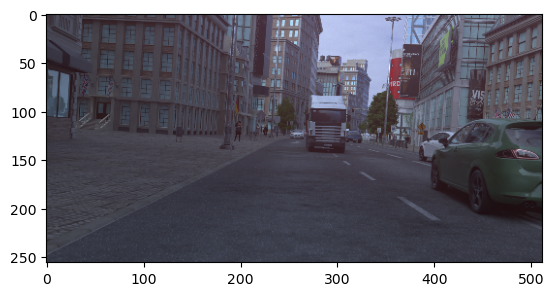

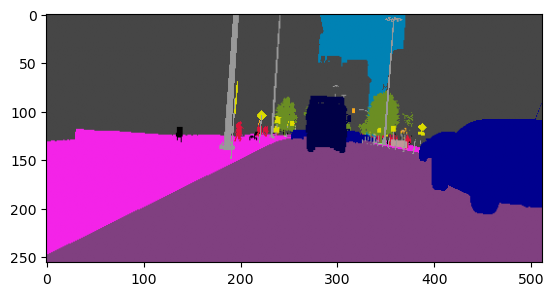

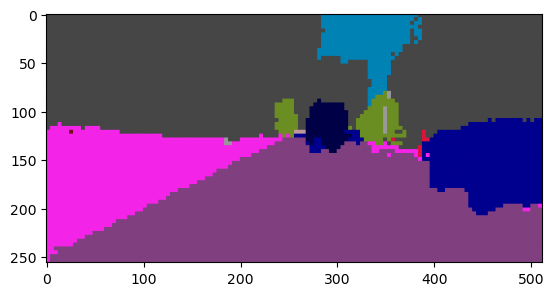

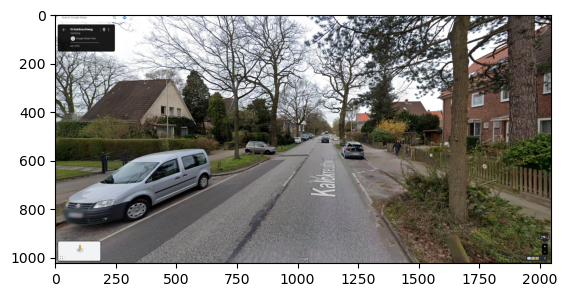

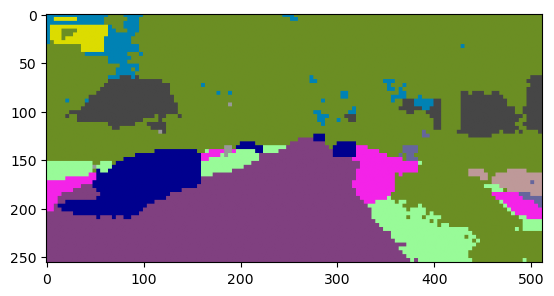

downscaling:  2
Validation mIoU: 31.80%

Validation mIoU per class:
unlabelled 0.00%
road 96.74%
sidewalk 77.01%
building 89.34%
wall 0.30%
fence 7.48%
pole 22.57%
traffic_light 11.24%
traffic_sign 25.86%
vegetation 72.23%
terrain 0.20%
sky 88.58%
person 42.18%
rider 1.14%
car 79.45%
truck 21.69%
bus 0.00%
train 0.00%
motorcycle 0.00%
bicycle 0.00%


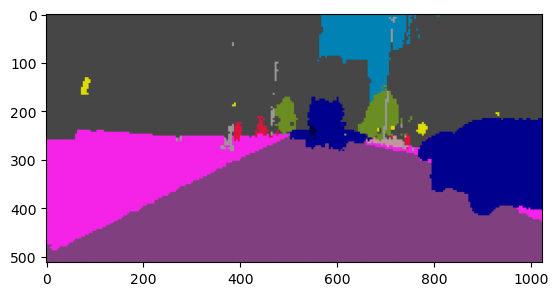

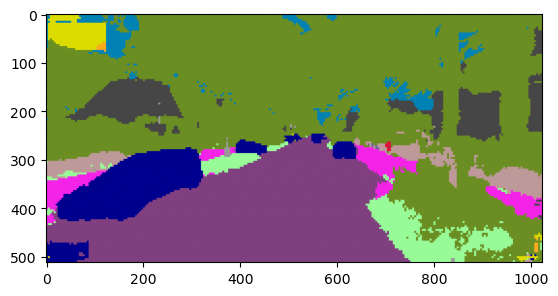

In [18]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")
evaluate(model, True, True)

c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


downscaling:  4
Validation mIoU: 34.92%

Validation mIoU per class:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050980445..1.1155555].


unlabelled 0.00%
road 96.61%
sidewalk 77.14%
building 90.36%
wall 8.12%
fence 7.88%
pole 25.73%
traffic_light 26.09%
traffic_sign 39.84%
vegetation 71.84%
terrain 10.74%
sky 87.26%
person 40.62%
rider 4.17%
car 82.35%
truck 29.74%
bus 0.00%
train 0.00%
motorcycle 0.00%
bicycle 0.00%


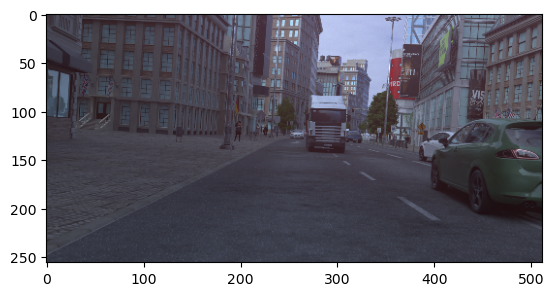

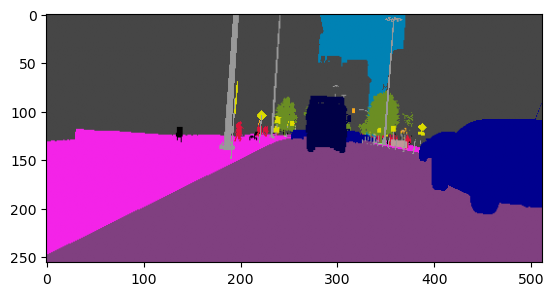

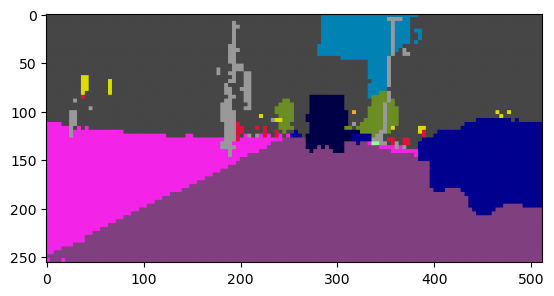

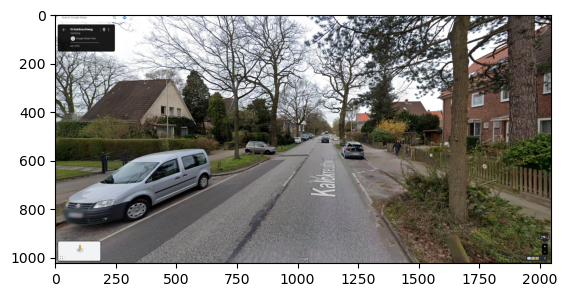

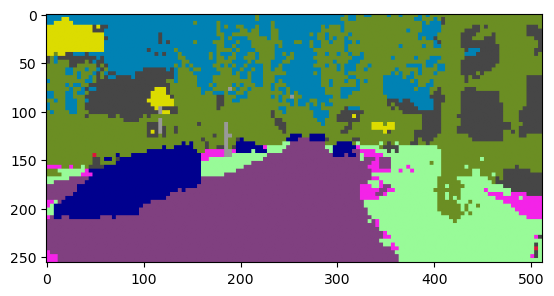

downscaling:  2
Validation mIoU: 38.83%

Validation mIoU per class:
unlabelled 0.00%
road 97.36%
sidewalk 81.64%
building 91.19%
wall 7.52%
fence 8.83%
pole 38.18%
traffic_light 31.05%
traffic_sign 48.85%
vegetation 77.74%
terrain 20.82%
sky 88.30%
person 52.32%
rider 6.79%
car 86.55%
truck 39.49%
bus 0.00%
train 0.00%
motorcycle 0.00%
bicycle 0.00%


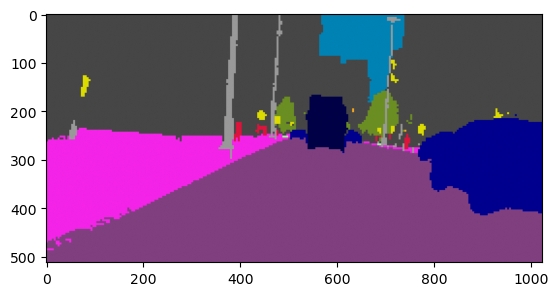

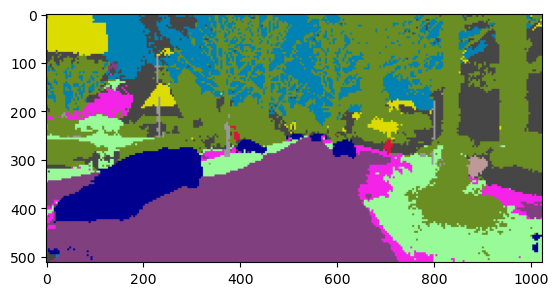

In [26]:
#lightning_model = UrbanSynSemanticSegmentation(learning_rate=LR, lr_gamma=LR_GAMMA, batch_size=BATCH_SIZE)
ckpt = 'epoch=102-val_loss=0.3926.ckpt'
lightning_model = UrbanSynSemanticSegmentation.load_from_checkpoint(os.path.join('lightning_logs', version_name, ckpt))

evaluate(lightning_model.model.cpu(), True, True)